Starting training
yes
yes
yes
yes
yes
yes
Starting Validation
Epoch number 0
 Training loss 1.5754111626423228
 Validation loss 9.651542986282195

Training Details
training Accuracy = 0.543731778425656
Average Distance for 0 label = 1.571886142377149
Average Distance for 1 label = 2.1279681685441982 

Validation Details
Validation Accuracy = 0.5151515151515151
Average Distance for 0 label = 4.301397114992142
Average Distance for 1 label = 22.724605335908777 

Starting training
yes
yes
yes
yes
yes
yes
Starting Validation
Epoch number 1
 Training loss 0.6338002051201191
 Validation loss 10.692245832597367

Training Details
training Accuracy = 0.8629737609329446
Average Distance for 0 label = 0.8641311685355861
Average Distance for 1 label = 2.5366617500782014 

Validation Details
Validation Accuracy = 0.5555555555555556
Average Distance for 0 label = 3.609887711026452
Average Distance for 1 label = 19.11478266282515 

Starting training
yes
yes
yes
yes
yes
yes
Starting Validation
Epoch nu

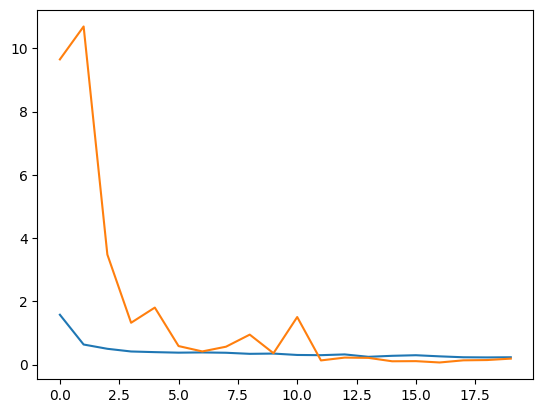

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import random
from PIL import Image
import os
import pandas as pd
from random import randint
import statistics
import torchvision
import torch
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils
from torch.autograd import Variable  
from torch.utils import data
import torchvision.datasets as dset
from torch.utils.data import DataLoader,Dataset
from torch import optim

from siamese_new_classes import ContrastiveLossk, siamese_Dataset_no_mode
from siamese_new_network import PretrainedNet
'''
import wandb
wandb.init(project="Siamese_gan_testing", entity="danielanojan", name = "testing_alexnet")
'''
os.environ['CUDA_LAUNCH_BLOCKING']='1'
os.environ['CUDA_VISIBLE_DEVICES']='0' # pick GPU to use
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")


class Config():
    train_batch_size = 1
    train_number_epochs = 20
    training_table = pd.read_csv('/mnt/recsys/daniel/datasets/ffhq_gan_generated_siamese_training/full_img_folders/csv_files/train_file.csv')
    testing_table = pd.read_csv('/mnt/recsys/daniel/datasets/ffhq_gan_generated_siamese_training/full_img_folders/csv_files/test_file.csv')
    image_dir = '/mnt/recsys/daniel/datasets/ffhq_gan_generated_siamese_training/full_img_folders'
    learning_rate = 0.0001
    contrastive_margin = 2.5
    euclidean_distance_threshold = 1.0
    pretrained_model = 'resnet18'
    

net = PretrainedNet(model= Config.pretrained_model).cuda()
criterion = ContrastiveLossk(margin = Config.contrastive_margin)
optimizer = optim.Adam(net.parameters(),lr = Config.learning_rate)


training_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5), # aim to train to be invariant to laterality of eye
    transforms.RandomRotation(15), # rotate +/- 5 degrees around center    # pixel crop
    transforms.ColorJitter(brightness = 0.5, contrast = 0.5), # brightness and color variation of +/- 5%
    transforms.RandomResizedCrop(size=(256, 256), scale=(0.8, 1.0)),
    transforms.ToTensor()
])

validation_transforms = transforms.Compose([ # pixel crop
    transforms.ToTensor()
])
'''
validation_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5), # aim to train to be invariant to laterality of eye
    transforms.RandomRotation(15), # rotate +/- 5 degrees around center    # pixel crop
    transforms.ColorJitter(brightness = 0.5, contrast = 0.5), # brightness and color variation of +/- 5%
    transforms.RandomResizedCrop(size=(256, 256), scale=(0.8, 1.0)),
    transforms.ToTensor()
])
'''

training_siamese_dataset = siamese_Dataset_no_mode(patient_table = Config.training_table,
                                          image_dir = Config.image_dir,
                                          transform = training_transforms,
                                          )

train_dataloader = torch.utils.data.DataLoader(training_siamese_dataset,
                                                  batch_size=Config.train_batch_size,
                                                  shuffle=True,
                                                  num_workers=0)


testing_siamese_dataset = siamese_Dataset_no_mode(patient_table = Config.testing_table,
                                          image_dir = Config.image_dir,
                                          transform = validation_transforms,
                                          )

test_dataloader = torch.utils.data.DataLoader(testing_siamese_dataset,
                                                  batch_size=1,
                                                  shuffle=False,
                                                  num_workers=0)


counter = []
training_loss_history = [] 
validation_loss_history = []

iteration_number= 0

checkpoints_dir = "./ckpt/{}".format('resnet_final')
CkptisExist = os.path.exists(checkpoints_dir)
if not CkptisExist:
   os.makedirs(checkpoints_dir)


for epoch in range(0,Config.train_number_epochs):
    training_loss = 0
    
    count = 0
    training_accuracy_history = []
    training_euclidean_distance_history = []
    training_label_history = []
    
    
    
    validation_accuracy_history = []
    validation_euclidean_distance_history = []
    validation_label_history = []
    
    net.train()
    print ('Starting training')
    for i, data in enumerate(train_dataloader,0):
        #print ('hi')
        img0, img1 , label, img_name1, img_name2 = data
        #print (img_name1[0], img_name2[0], label[0].item())
        #print (img0.shape, img1.shape)
        img0, img1 , label = img0.cuda(), img1.cuda(), label.cuda(),
        optimizer.zero_grad()
        output1, output2 = net.forward(img0,img1)
        loss_contrastive, euclidean_distance = criterion(output1,output2,label)
        loss_contrastive.backward()
        optimizer.step()
        training_loss += loss_contrastive.item()

        #print (training_loss)
        #if count % 100 == 0:
        #    print (training_loss/count)
        
        training_label = euclidean_distance > Config.euclidean_distance_threshold
        equals = training_label.int().detach().cpu().numpy().flatten() == label.int().cpu().numpy()
        #acc_tmp = torch.Tensor.numpy(equals.cpu())
        training_accuracy_history.extend(equals)

        # save euclidean distance and label history 
        euclid_tmp = torch.Tensor.numpy(euclidean_distance.detach().cpu()) # detach gradient, move to CPU
        training_euclidean_distance_history.extend(euclid_tmp)
        label_tmp = torch.Tensor.numpy(label.cpu())
        training_label_history.extend(label_tmp)
        
        count += 1
        if count %100 ==0:
            print ("yes")
        
    else:
        validation_loss = 0
        count_correct_valid = 0
        
        label_0_distance_valid = 0; label_1_distance_valid = 0
        label_0_count_valid = 0;  label_1_count_valid = 0 
        
        
        net.eval() 
        print ("Starting Validation")
        with torch.no_grad():
            for i, data_v in enumerate(test_dataloader, 0):
                img0_v, img1_v , label_v, _, _ = data_v
                img0_v, img1_v , label_v = img0_v.cuda(), img1_v.cuda() , label_v.cuda()
                output_v1, output_v2 = net.forward(img0_v,img1_v)
                loss_contrastive_v, euclidean_distance_v = criterion(output_v1, output_v2, label_v.float())
                validation_loss += loss_contrastive_v.item()

                testing_label = euclidean_distance_v > Config.euclidean_distance_threshold
                equals = testing_label.int().detach().cpu().numpy().flatten() == label_v.int().cpu().numpy()
                validation_accuracy_history.extend(equals)

                euclid_tmp = torch.Tensor.numpy(euclidean_distance_v.detach().cpu()) # detach gradient, move to CPU
                validation_euclidean_distance_history.extend(euclid_tmp)
                label_tmp = torch.Tensor.numpy(label_v.cpu())
                validation_label_history.extend(label_tmp)
        
        
            
            
    training_accuracy = statistics.mean(np.array(training_accuracy_history).tolist())        
    euclid_if_0_t = [b for a, b in zip(training_label_history, training_euclidean_distance_history) if a == 0]
    euclid_if_1_t= [b for a, b in zip(training_label_history, training_euclidean_distance_history) if a == 1]
    euclid_if_0_t = np.array(euclid_if_0_t).flatten().tolist()
    euclid_if_1_t = np.array(euclid_if_1_t).flatten().tolist()

    # summary statistics for euclidean distances
    mean_euclid_0t = statistics.mean(euclid_if_0_t) 
    std_euclid_0t = statistics.pstdev(euclid_if_0_t)       
    mean_euclid_1t = statistics.mean(euclid_if_1_t)
    std_euclid_1t = statistics.pstdev(euclid_if_1_t)
    
    
    validation_accuracy = statistics.mean(np.array(validation_accuracy_history).tolist())        
    euclid_if_0_v = [b for a, b in zip(validation_label_history, validation_euclidean_distance_history) if a == 0]
    euclid_if_1_v= [b for a, b in zip(validation_label_history, validation_euclidean_distance_history) if a == 1]
    euclid_if_0_v = np.array(euclid_if_0_v).flatten().tolist()
    euclid_if_1_v = np.array(euclid_if_1_v).flatten().tolist()

    # summary statistics for euclidean distances
    mean_euclid_0v = statistics.mean(euclid_if_0_v) 
    std_euclid_0v = statistics.pstdev(euclid_if_0_v)       
    mean_euclid_1v = statistics.mean(euclid_if_1_v)
    std_euclid_1v = statistics.pstdev(euclid_if_1_v)
    
    training_loss_avg = training_loss/len(train_dataloader)
    validation_loss_avg = validation_loss/len(test_dataloader)
    #print (same_class_loss, count_same_class, other_class_loss, count_other_class)
    print("Epoch number {}\n Training loss {}\n Validation loss {}\n".format(epoch, training_loss_avg, validation_loss_avg))
    #print ("Same class loss{}\n same class count {} \n".format(same_class_loss.item()/count_same_class, count_same_class))
    #print ("Other class loss{}\n other class count {} \n".format(other_class_loss.item()/count_other_class, count_other_class))
    
    print ("Training Details")
    print ("training Accuracy = {}".format(training_accuracy))
    print ("Average Distance for 0 label = {}".format(mean_euclid_0t))
    print ("Average Distance for 1 label = {} \n".format(mean_euclid_1t))
    
    print ("Validation Details")
    print ("Validation Accuracy = {}".format(validation_accuracy))
    print ("Average Distance for 0 label = {}".format(mean_euclid_0v))
    print ("Average Distance for 1 label = {} \n".format(mean_euclid_1v))
    '''
    wandb.log({"Training_accuracy": training_accuracy, "Training loss":training_loss_avg, "Validation loss":validation_loss_avg, "Validation accuracy":validation_accuracy, 
              "mean_euclid_0v": mean_euclid_0v, "mean_euclid_1v": mean_euclid_1v, "mean_euclid_0t": mean_euclid_0t, "mean_euclid_1t": mean_euclid_1t,
               "std_euclid_0v": std_euclid_0v, "std_euclid_1v": std_euclid_1v, "std_euclid_0t": std_euclid_0t, "std_euclid_1t":std_euclid_1t
              })
    wandb.watch(net)
    '''
    
    counter.append(epoch)
    #Config.euclidean_distance_threshold = (mean_euclid_0v + mean_euclid_1v) / 2
    training_loss_history.append(training_loss/len(train_dataloader))
    validation_loss_history.append(validation_loss/len(test_dataloader))
    torch.save(net.state_dict(), checkpoints_dir + "/base_model_epoch{}.pth".format(epoch))

plt.plot(training_loss_history)
plt.plot(validation_loss_history)
plt.show()

In [10]:
import torchvision
model = torchvision.models.mobilenet_v2()

In [11]:
#print (model)

In [2]:

#net = SiameseNetworkbasic().cuda()


Starting training
Starting Validation
Epoch number 0
 Training loss 5.22326801544012
 Validation loss 2.850833917409998

Training Details
training Accuracy = 0.5029154518950437
Average Distance for 0 label = 1.4807711834190813
Average Distance for 1 label = 1.5427058570914798 

Validation Details
Validation Accuracy = 0.5050505050505051
Average Distance for 0 label = 3.162277789670043e-05
Average Distance for 1 label = 3.162277789670043e-05 

Starting training
Starting Validation
Epoch number 1
 Training loss 1.541365631097971
 Validation loss 3.0835550534434684

Training Details
training Accuracy = 0.5029154518950437
Average Distance for 0 label = 1.3349903498122941
Average Distance for 1 label = 1.2952926687025956 

Validation Details
Validation Accuracy = 0.46464646464646464
Average Distance for 0 label = 3.162277789670043e-05
Average Distance for 1 label = 3.162277789670043e-05 

Starting training
Starting Validation
Epoch number 2
 Training loss 1.5084073605925539
 Validation loss

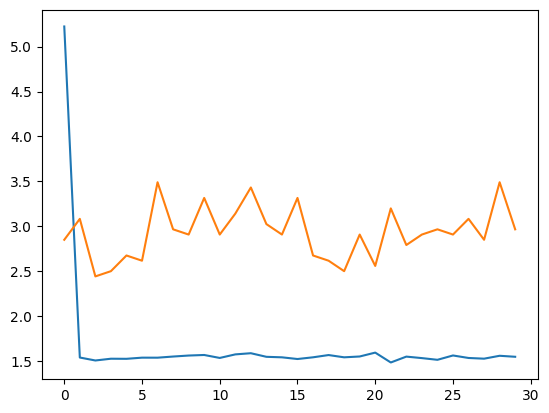

In [3]:
counter = []
training_loss_history = [] 
validation_loss_history = []

iteration_number= 0

checkpoints_dir = "./ckpt/{}".format(Config.pretrained_model)
CkptisExist = os.path.exists(checkpoints_dir)
if not CkptisExist:
   os.makedirs(checkpoints_dir)


for epoch in range(0,Config.train_number_epochs):
    training_loss = 0
    
    count = 0
    training_accuracy_history = []
    training_euclidean_distance_history = []
    training_label_history = []
    
    
    
    validation_accuracy_history = []
    validation_euclidean_distance_history = []
    validation_label_history = []
    
    net.train()
    print ('Starting training')
    for i, data in enumerate(train_dataloader,0):
        #print ('hi')
        img0, img1 , label, img_name1, img_name2 = data
        #print (img_name1[0], img_name2[0], label[0].item())
        #print (img0.shape, img1.shape)
        img0, img1 , label = img0.cuda(), img1.cuda(), label.cuda(),
        optimizer.zero_grad()
        output1, output2 = net.forward(img0,img1)
        loss_contrastive, euclidean_distance = criterion(output1,output2,label)
        loss_contrastive.backward()
        optimizer.step()
        training_loss += loss_contrastive.item()

        #print (training_loss)
        #if count % 100 == 0:
        #    print (training_loss/count)
        
        training_label = euclidean_distance > Config.euclidean_distance_threshold
        equals = training_label.int().detach().cpu().numpy().flatten() == label.int().cpu().numpy()
        #acc_tmp = torch.Tensor.numpy(equals.cpu())
        training_accuracy_history.extend(equals)

        # save euclidean distance and label history 
        euclid_tmp = torch.Tensor.numpy(euclidean_distance.detach().cpu()) # detach gradient, move to CPU
        training_euclidean_distance_history.extend(euclid_tmp)
        label_tmp = torch.Tensor.numpy(label.cpu())
        training_label_history.extend(label_tmp)
        
        count += 1
        
    else:
        validation_loss = 0
        count_correct_valid = 0
        
        label_0_distance_valid = 0; label_1_distance_valid = 0
        label_0_count_valid = 0;  label_1_count_valid = 0 
        
        
        net.eval() 
        print ("Starting Validation")
        with torch.no_grad():
            for i, data_v in enumerate(test_dataloader, 0):
                img0_v, img1_v , label_v, _, _ = data_v
                img0_v, img1_v , label_v = img0_v.cuda(), img1_v.cuda() , label_v.cuda()
                output_v1, output_v2 = net.forward(img0_v,img1_v)
                loss_contrastive_v, euclidean_distance_v = criterion(output_v1, output_v2, label_v.float())
                validation_loss += loss_contrastive_v.item()

                testing_label = euclidean_distance_v > Config.euclidean_distance_threshold
                equals = testing_label.int().detach().cpu().numpy().flatten() == label_v.int().cpu().numpy()
                validation_accuracy_history.extend(equals)

                euclid_tmp = torch.Tensor.numpy(euclidean_distance_v.detach().cpu()) # detach gradient, move to CPU
                validation_euclidean_distance_history.extend(euclid_tmp)
                label_tmp = torch.Tensor.numpy(label_v.cpu())
                validation_label_history.extend(label_tmp)
        
        
            
            
    training_accuracy = statistics.mean(np.array(training_accuracy_history).tolist())        
    euclid_if_0_t = [b for a, b in zip(training_label_history, training_euclidean_distance_history) if a == 0]
    euclid_if_1_t= [b for a, b in zip(training_label_history, training_euclidean_distance_history) if a == 1]
    euclid_if_0_t = np.array(euclid_if_0_t).flatten().tolist()
    euclid_if_1_t = np.array(euclid_if_1_t).flatten().tolist()

    # summary statistics for euclidean distances
    mean_euclid_0t = statistics.mean(euclid_if_0_t) 
    std_euclid_0t = statistics.pstdev(euclid_if_0_t)       
    mean_euclid_1t = statistics.mean(euclid_if_1_t)
    std_euclid_1t = statistics.pstdev(euclid_if_1_t)
    
    
    validation_accuracy = statistics.mean(np.array(validation_accuracy_history).tolist())        
    euclid_if_0_v = [b for a, b in zip(validation_label_history, validation_euclidean_distance_history) if a == 0]
    euclid_if_1_v= [b for a, b in zip(validation_label_history, validation_euclidean_distance_history) if a == 1]
    euclid_if_0_v = np.array(euclid_if_0_v).flatten().tolist()
    euclid_if_1_v = np.array(euclid_if_1_v).flatten().tolist()

    # summary statistics for euclidean distances
    mean_euclid_0v = statistics.mean(euclid_if_0_v) 
    std_euclid_0v = statistics.pstdev(euclid_if_0_v)       
    mean_euclid_1v = statistics.mean(euclid_if_1_v)
    std_euclid_1v = statistics.pstdev(euclid_if_1_v)
    
    training_loss_avg = training_loss/len(train_dataloader)
    validation_loss_avg = validation_loss/len(test_dataloader)
    #print (same_class_loss, count_same_class, other_class_loss, count_other_class)
    print("Epoch number {}\n Training loss {}\n Validation loss {}\n".format(epoch, training_loss_avg, validation_loss_avg))
    #print ("Same class loss{}\n same class count {} \n".format(same_class_loss.item()/count_same_class, count_same_class))
    #print ("Other class loss{}\n other class count {} \n".format(other_class_loss.item()/count_other_class, count_other_class))
    
    print ("Training Details")
    print ("training Accuracy = {}".format(training_accuracy))
    print ("Average Distance for 0 label = {}".format(mean_euclid_0t))
    print ("Average Distance for 1 label = {} \n".format(mean_euclid_1t))
    
    print ("Validation Details")
    print ("Validation Accuracy = {}".format(validation_accuracy))
    print ("Average Distance for 0 label = {}".format(mean_euclid_0v))
    print ("Average Distance for 1 label = {} \n".format(mean_euclid_1v))
    
    wandb.log({"Training_accuracy": training_accuracy, "Training loss":training_loss_avg, "Validation loss":validation_loss_avg, "Validation accuracy":validation_accuracy, 
              "mean_euclid_0v": mean_euclid_0v, "mean_euclid_1v": mean_euclid_1v, "mean_euclid_0t": mean_euclid_0t, "mean_euclid_1t": mean_euclid_1t,
               "std_euclid_0v": std_euclid_0v, "std_euclid_1v": std_euclid_1v, "std_euclid_0t": std_euclid_0t, "std_euclid_1t":std_euclid_1t
              })
    wandb.watch(net)
    
    
    counter.append(epoch)
    #Config.euclidean_distance_threshold = (mean_euclid_0v + mean_euclid_1v) / 2
    training_loss_history.append(training_loss/len(train_dataloader))
    validation_loss_history.append(validation_loss/len(test_dataloader))
    torch.save(net.state_dict(), checkpoints_dir + "/base_model_epoch{}.pth".format(epoch))

plt.plot(training_loss_history)
plt.plot(validation_loss_history)
plt.show()

In [ ]:
plt.plot(training_loss_history[4:])
plt.plot(validation_loss_history[4:])
plt.show()

In [1]:
!pip install wandb --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 17.3 MB/s eta 0:00:00:00:01
  Attempting uninstall: wandb
    Found existing installation: wandb 0.13.10
    Uninstalling wandb-0.13.10:
      Successfully uninstalled wandb-0.13.10


In [ ]:
euclid_if_0 = [b for a, b in zip(training_label_history, training_euclidean_distance_history) if a == 0]
euclid_if_1 = [b for a, b in zip(training_label_history, training_euclidean_distance_history) if a == 1]
#euclid_if_0 = np.array(euclid_if_0).tolist()
#euclid_if_1 = np.array(euclid_if_1).tolist()

# summary statistics for euclidean distances
#mean_euclid_0t = statistics.mean(euclid_if_0) 
#std_euclid_0t = statistics.pstdev(euclid_if_0)       

#mean_euclid_1t = statistics.mean(euclid_if_1)
#std_euclid_1t = statistics.pstdev(euclid_if_1)   

In [2]:
training_accuracy

NameError: name 'training_accuracy' is not defined

In [18]:
l_b = label.int().cpu().numpy()

In [19]:
equal = t_l == l_b

In [20]:
equal

array([ True, False, False,  True])

In [21]:
t_l

array([0, 0, 0, 1], dtype=int32)

In [22]:
l_b

array([0, 1, 1, 1], dtype=int32)

In [ ]:
class TestConfig():
    testing_table = pd.read_csv('/mnt/recsys/daniel/simase_network/dataset_256_0_pct_all/csv_files/gan_train_file.csv')
    image_dir = '/mnt/recsys/daniel/simase_network/dataset_256_0_pct_all/data'
    scores_csv_file = pd.read_csv('/mnt/recsys/daniel/datasets/gan_masks_classify_cleft/cleft_lip_scores.csv')

In [ ]:
class siamese_test_Dataset(torch.utils.data.Dataset):

    def __init__(self, patient_table, image_dir,scores_csv_file,  transform=None ):
        
        self.patient_table = patient_table
        self.image_dir = image_dir
        self.transform = transform
        self.epoch_size = len(self.patient_table)
        self.scroes_file = scores_csv_file
        if self.transform is None:
            self.transform = transforms.Compose([transforms.ToTensor()])

    def __len__(self):
        return self.epoch_size

    def __getitem__(self, idx):
        name_list = self.patient_table
        num_entries = len(name_list)
        label = 1

        while True:
            #random_image = random.choice(name_list).split('.')[0]+'.png' # note that processed images are all .png type, while patient_table has different types

            random_num = randint(0, num_entries-1)
            #random_image_row = random.choice(name_list)

            random_image_row = name_list.iloc[random_num]
            random_image = random_image_row['File_name']
            #if random_image in os.listdir(os.path.join(self.image_dir, self.mode, random_image_row['class'])):
            patient_id = random_image.split(".")[0][:-5]
            paired_image = patient_id + 'out.png'
            print (patient_id[:-1])
            if (random_image in os.listdir(os.path.join(self.image_dir, "truth"))) and (paired_image in os.listdir(os.path.join(self.image_dir,  "out"))):
                break
            elif paired_image in os.listdir(os.path.join(self.image_dir, "out")):
                print('attempted to get following image, but missing: ' + random_image)
            elif random_image in os.listdir(os.path.join(self.image_dir,  "truth")):
                print('attempted to get following image, but missing: ' + paired_image)

            img_name1 = random_image.split('.')[0].split('_')[:2]
            img_name2 = paired_image.split('.')[0].split('_')[:2]

            if img_name1 == img_name2:
                break
        doctor_score = self.scroes_file.loc[self.scroes_file['Patient number'].isin([patient_id[:-1]])]['Lip Score'].item()
        random_img_dir = os.path.join(self.image_dir,  "truth")
        paired_img_dir = os.path.join(self.image_dir,  "out")
        img0 = Image.open(random_img_dir +'/' +random_image).convert("RGB")
        img1 = Image.open(paired_img_dir +'/' +paired_image).convert("RGB")

        k1, k2 = img0.size, img1.size
        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        return img0, img1, label, doctor_score



In [ ]:

checkpoints_dir = "./ckpt"
test_epoch = 15

test_model = SiameseNetworkbasic().cuda()
test_model.load_state_dict(torch.load(checkpoints_dir + "/base_model_epoch{}.pth".format(test_epoch)))


test_transforms = transforms.Compose([ # pixel crop
    transforms.ToTensor()
])



testing_siamese_dataset = siamese_test_Dataset(patient_table = TestConfig.testing_table,
                                          image_dir = TestConfig.image_dir,
                                          scores_csv_file = TestConfig.scores_csv_file,
                                          transform = test_transforms)

test_dataloader = torch.utils.data.DataLoader(testing_siamese_dataset,
                                                  batch_size=1,
                                                  shuffle=True,
                                                  num_workers=0)

dataiter = iter(test_dataloader)

scores_list = []
dissimilarity_score = []
x_axis = [x for x in range(50)]

#len(test_dataloader)

for test_cnt in range(50):
    x_0, x_1, _ , score= next(dataiter)
    concatenated = torch.cat((x_0,x_1),0)
    output1,output2 = net(Variable(x_0).cuda(),Variable(x_1).cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    scores_list.append(score.item())
    dissimilarity_score.append(euclidean_distance.item()*1000)
    #imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}_Score{:.2f}'.format(euclidean_distance.item()*1000,score.item() ))
    
    

In [ ]:
plt.plot(scores_list)
plt.plot(dissimilarity_score)
plt.show()

In [ ]:
x_axis

In [ ]:
x1 = x_axis
y1 = dissimilarity_score

# Create example data for the second plot (plot2) with a different range
x2 = x1
y2 = scores_list  # Scaled for a different range

# Create a figure and the first set of axes
fig, ax1 = plt.subplots()
ax1.set_xlabel('X-axis')
ax1.set_ylabel('Y1', color='tab:blue')  # Label for the first plot

# Plot the first set of data on the first set of axes
ax1.plot(x1, y1, color='tab:blue', label='Plot 1')

# Create the second set of axes that shares the same x-axis
ax2 = ax1.twinx()
ax2.set_ylabel('Y2', color='tab:red')  # Label for the second plot

# Plot the second set of data on the second set of axes
ax2.plot(x2, y2, color='tab:red', label='Plot 2')

# Add legends for both plots
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Display the plots
plt.title('Two Graphs with Differing Ranges')
plt.show()


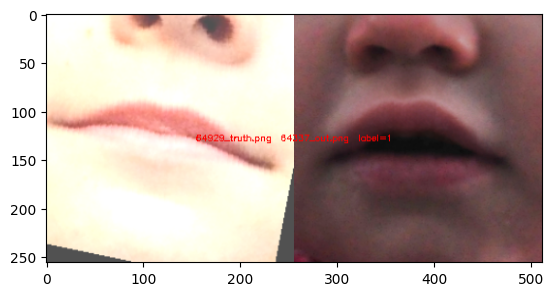

In [16]:
import cv2

x, y, label, name1, name2 = next(iter(train_dataloader))

img1 = np.transpose(x[0].numpy(), (1, 2, 0))
img2 = np.transpose(y[0].numpy(), (1, 2, 0))
img_combined = np.concatenate((img1, img2), axis=1)
height, width, _ = img_combined.shape

font = cv2.FONT_HERSHEY_SIMPLEX
text = name1[0]+ "  " + name2[0] + "  label="  + str(label[0].item())
font_size = 0.3
font_thickness = 1
font_color = (255, 0, 0)
img_combined = np.ascontiguousarray((img_combined*255).astype('uint8'))
(text_width, text_height), baseline = cv2.getTextSize(text, font, font_size, font_thickness)
text_position = ((width - text_width) // 2, (height + text_height) // 2)
cv2.putText(img_combined, text, text_position, font, font_size, font_color, font_thickness);
plt.imshow(img_combined)

In [26]:
TestConfig.scores_csv_file[1:10]

,Patient number,Lip Score
1,2012_10,4.67
2,2012_11,1.67
3,2012_12,2.33
4,2012_13,1.67
5,2012_14,3.33
6,2012_15,1.67
7,2012_16,2.00
8,2012_17,3.00
9,2012_18,4.00


In [10]:
counter

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

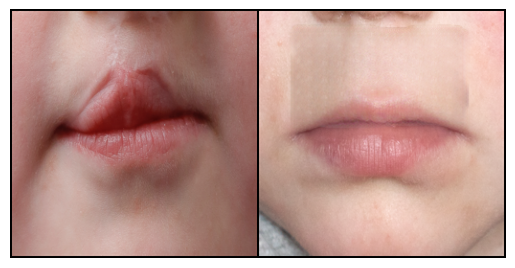

[1]


In [11]:
#visualizing inputs


vis_dataloader = torch.utils.data.DataLoader(testing_siamese_dataset,
                                                  batch_size=1,
                                                  shuffle=True,
                                                  num_workers=0)



dataiter = iter(vis_dataloader)
example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

In [12]:
example_batch[1].shape

torch.Size([1, 3, 256, 256])

In [32]:
from torchvision import transforms, models

class SiameseAlexnet(nn.Module):
    """
    Siamese neural network
    Modified from: https://hackernoon.com/facial-similarity-with-siamese-networks-in-pytorch-9642aa9db2f7
    Siamese ResNet-101 from Pytorch library
    """
    def __init__(self):
        super(SiameseAlexnet, self).__init__()
        # note that resnet101 requires 3 input channels, will repeat grayscale image x3
        #self.cnn1 = models.resnet101(pretrained = True)
        self.cnn1 = models.alexnet(pretrained = True)
        #for param in self.cnn1.parameters():
        #    param.requires_grad = False
        #self.cnn1.fc = nn.Linear(2048, 512) # mapping input image to a 3 node output
        for name, para in self.cnn1.named_parameters():
            if para.requires_grad:
                print (name)

    def forward_once(self, x):
        output = self.cnn1(x)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

    
alex = SiameseAlexnet()

ValueError: The parameter 'num_classes' expected value 1000 but got 2 instead.

In [31]:
#prints output of every layer in the network


def print_layer_output_sizes(model, input_size):
    def forward_hook(module, input, output):
        print(f"Layer: {module.__class__.__name__}")
        print(f"Input size: {str(input[0].shape)}")
        print(f"Output size: {str(output.shape)}")
        print("------------------")

    hooks = []
    for name, layer in model.named_children():
        hook = layer.register_forward_hook(forward_hook)
        hooks.append(hook)

    # Put the model in evaluation mode
    model.eval()

    # Perform a forward pass with a dummy input to trigger the hooks
    with torch.no_grad():
        model(input_size, input_size)

    # Remove the hooks
    for hook in hooks:
        hook.remove()

alex = SiameseAlexnet()
input_tensor1 = torch.randn(1, 3, 256, 256)  # Adjust input size as needed
#input_tensor2 = torch.randn(1, 3, 224, 224)
# Print the output sizes
print_layer_output_sizes(alex, input_tensor1)

features.0.weight
features.0.bias
features.3.weight
features.3.bias
features.6.weight
features.6.bias
features.8.weight
features.8.bias
features.10.weight
features.10.bias
classifier.1.weight
classifier.1.bias
classifier.4.weight
classifier.4.bias
classifier.6.weight
classifier.6.bias
Layer: AlexNet
Input size: torch.Size([1, 3, 256, 256])
Output size: torch.Size([1, 1000])
------------------
Layer: AlexNet
Input size: torch.Size([1, 3, 256, 256])
Output size: torch.Size([1, 1000])
------------------


In [ ]:
class siamese_Dataset(torch.utils.data.Dataset):
    """
    Create dataset representation of ROP data
    - This class returns image pairs with a change label (i.e. change vs no change in a categorical disease severity label) and other metadata
    - Image pairs are sampled so that there are an equal number of change vs no change labels
    - Epoch size can be set for empirical testing

    Concepts adapted from:
    - https://hackernoon.com/facial-similarity-with-siamese-networks-in-pytorch-9642aa9db2f7
    - https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
    """
    def __init__(self, patient_table, image_dir, mode, transform=None):
        """
        Args:
            patient_table (pd.dataframe): dataframe table containing image names, disease severity category label, and other metadata
            image_dir (string): directory containing all of the image files
            transform (callable, optional): optional transform to be applied on a sample
        """
        self.patient_table = patient_table
        self.image_dir = image_dir
        self.transform = transform
        self.epoch_size = len(self.patient_table)
        self.mode = mode
        if self.transform is None:
            self.transform = transforms.Compose([transforms.ToTensor()])

    def __len__(self):
        return self.epoch_size

    def __getitem__(self, idx):
        #you should change this part-------------------------------------------------------------------
        name_list = self.patient_table
        num_entries = len(name_list)
        # goal is 50:50 distribution of change vs no change
        change_binary = random.randint(0,1)
        label = None
        # keep on looping until no change pair created
        while change_binary == 0:

            while True:
                #random_image = random.choice(name_list).split('.')[0]+'.png' # note that processed images are all .png type, while patient_table has different types

                random_num = randint(0, num_entries-1)
                #random_image_row = random.choice(name_list)

                random_image_row = name_list.iloc[random_num]
                random_image = random_image_row['File_name']
                #if random_image in os.listdir(os.path.join(self.image_dir, self.mode, random_image_row['class'])):

                paired_image = random_image.split(".")[0][:-5] + 'out.png'
                #print (random_image ,"\n", paired_image)
                if (random_image in os.listdir(os.path.join(self.image_dir, self.mode, "truth"))) and (paired_image in os.listdir(os.path.join(self.image_dir, self.mode,  "out"))):
                    break
                elif paired_image in os.listdir(os.path.join(self.image_dir, self.mode,  "out")):
                    print('attempted to get following image, but missing: ' + random_image)
                elif random_image in os.listdir(os.path.join(self.image_dir, self.mode, "truth")):
                    print('attempted to get following image, but missing: ' + paired_image)

            img_name1 = random_image.split('.')[0].split('_')[:2]
            img_name2 = paired_image.split('.')[0].split('_')[:2]

            if img_name1 == img_name2:
                label = 0
                break

        # keep on looping until change pair created
        while change_binary == 1:

            # pick random image from folder
            # check to see if the image exists and can be loaded, if not move to another random image
            while True:

                random_num = randint(0, num_entries - 1)
                pair_num = randint(0, num_entries - 1)
                if random_num == pair_num:
                    continue

                # random_image_row = random.choice(name_list)

                random_image_row = name_list.iloc[random_num]
                random_image = random_image_row['File_name']

                paired_image_row = name_list.iloc[pair_num]
                paired_image = paired_image_row['File_name'].split(".")[0][:-5] + 'out.png'
                
                print (random_image ,"\n", paired_image)
                if (random_image in os.listdir(os.path.join(self.image_dir, self.mode, "truth"))) and (paired_image in os.listdir(os.path.join(self.image_dir, self.mode, "out"))):
                    break
                elif paired_image in os.listdir(os.path.join(self.image_dir, self.mode,  "out")):
                    print('attempted to get following image, but missing: ' + random_image)
                elif random_image in os.listdir(os.path.join(self.image_dir,  self.mode, "truth")):
                    print('attempted to get following image, but missing: ' + paired_image)

            img_name1 = random_image.split('.')[0].split('_')[:2]
            img_name2 = paired_image.split('.')[0].split('_')[:2]

            if img_name1 != img_name2:
                label = 1
                break

        random_img_dir = os.path.join(self.image_dir,  self.mode, "truth")
        paired_img_dir = os.path.join(self.image_dir,  self.mode, "out")
        img0 = Image.open(random_img_dir +'/' +random_image).convert("RGB")
        img1 = Image.open(paired_img_dir +'/' +paired_image).convert("RGB")

        #img0 = img0.convert("L")            #converting to grayscale
        #img1 = img1.convert("L")            #converting to grayscale
        k1, k2 = img0.size, img1.size
        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        #print ('bhghjagfhafgdhsfgdhjgfhghghjfgdhjg',img0.shape)
        return img0, img1, label



In [1]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


        )

        self.fc1 = nn.Sequential(
            nn.Linear(8*100*100, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 5))

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

NameError: name 'nn' is not defined

In [2]:
class SiameseNetworkbasic(nn.Module):
    def __init__(self):
        super(SiameseNetworkbasic, self).__init__()

        # Shared feature extraction layers (twin branches)
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 32, 5),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(32, 64, 3),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(64, 64, 3),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.MaxPool2d(2,2)
        )

        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Linear(64*30*30, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.3),
            
            nn.Linear(1024, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.3),
            
            nn.Linear(256, 2)  # 2 output dimensions for similarity scoring
        )
    
    
    def forward_one(self, x):
        # Forward pass through one branch of the Siamese network
        output = self.cnn(x)
        output = output.view(output.size()[0], -1)
        output = self.fc(output)
        return output

    def forward(self, input1, input2):
        # Forward pass through both branches
        output1 = self.forward_one(input1)
        output2 = self.forward_one(input2)
        return output1, output2

    

NameError: name 'nn' is not defined